In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# 准备数据

In [2]:
# 加载加利福尼亚房价数据集
housing = fetch_california_housing()
X = housing.data
y = housing.target

# 数据拆分：训练集(64%)、验证集(16%)、测试集(20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)  # 0.25 x 0.8 = 0.2

print(f"训练集大小: {X_train.shape[0]}")
print(f"验证集大小: {X_val.shape[0]}")
print(f"测试集大小: {X_test.shape[0]}")

训练集大小: 13209
验证集大小: 3303
测试集大小: 4128


In [3]:
# 数据标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 自定义数据集类
class HousingDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets).view(-1, 1)
        
    def __len__(self):
        return len(self.features) #返回样本数量
    
    def __getitem__(self, idx): #传入索引，返回对应索引样本的特征和目标
        return self.features[idx], self.targets[idx]

# 创建数据集实例
train_dataset = HousingDataset(X_train_scaled, y_train)
val_dataset = HousingDataset(X_val_scaled, y_val)
test_dataset = HousingDataset(X_test_scaled, y_test)

In [4]:
# Adam优化器的特点
"""
Adam优化器的特点
1. 自适应学习率 - 为每个参数计算不同的学习率，适应性强
2. 结合了动量Momentum和RMSProp的优点 - 加速收敛并处理稀疏梯度
3. 偏差修正 - 修正初始训练阶段的估计偏差
4. 计算效率高 - 计算量小，内存需求低
5. 超参数稳健 - 默认超参数通常工作良好，不需要频繁调整
"""

# Adam优化器参数说明
"""
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
参数解释：
- lr: 学习率，控制参数更新步长,默认: 0.001
- betas: 用于计算梯度及其平方的运行平均值的系数,默认: (0.9, 0.999)
- eps: 添加到分母以提高数值稳定性的项,默认: 1e-8
- weight_decay: 权重衰减L2惩罚,默认: 0
"""

'\noptimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)\n参数解释：\n- lr: 学习率，控制参数更新步长,默认: 0.001\n- betas: 用于计算梯度及其平方的运行平均值的系数,默认: (0.9, 0.999)\n- eps: 添加到分母以提高数值稳定性的项,默认: 1e-8\n- weight_decay: 权重衰减L2惩罚,默认: 0\n'

In [5]:
# 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# 定义神经网络模型
class HousingModel(nn.Module):
    def __init__(self, input_size):
        super(HousingModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 30)  # 输入层到30个神经元的隐藏层
        self.activation = nn.ReLU()  # 激活函数
        self.layer2 = nn.Linear(30, 1)  # 隐藏层到输出层
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        return x

# 初始化模型
input_size = X_train.shape[1]  # 特征数量，8列数据
model = HousingModel(input_size) #初始化模型，输入8列数据，输出1列数据

# 定义损失函数和优化器
criterion = nn.MSELoss()  # 均方误差损失函数
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam优化器

# 训练模型
num_epochs = 100
train_losses = []
val_losses = []

global_step = 0
# 导入tqdm用于进度条显示
from tqdm import tqdm

# 计算20%进度的epoch数
progress_step = max(1, num_epochs // 5)

for epoch in range(num_epochs):
    # 训练模式
    model.train()
    train_loss = 0
    # 使用tqdm包装训练数据加载器
    for features, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} 训练", leave=False):
        # 前向传播
        outputs = model(features)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # 验证模式
    model.eval()
    val_loss = 0
    with torch.no_grad():
        # 使用tqdm包装验证数据加载器
        for features, targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} 验证", leave=False):
            outputs = model(features)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    
    # 每20%的进度打印一次损失
    if (epoch + 1) % progress_step == 0 or epoch == 0 or epoch == num_epochs - 1:
        print(f'Epoch [{epoch+1}/{num_epochs}], 训练损失: {train_loss:.4f}, 验证损失: {val_loss:.4f}')


Epoch [1/100], 训练损失: 3.0656, 验证损失: 1.2091


Epoch [20/100], 训练损失: 0.3554, 验证损失: 0.3819


Epoch [40/100], 训练损失: 0.3376, 验证损失: 0.3759


Epoch [60/100], 训练损失: 0.3275, 验证损失: 0.3578


Epoch [80/100], 训练损失: 0.3185, 验证损失: 0.3598


Epoch [100/100], 训练损失: 0.3143, 验证损失: 0.3467


In [6]:

# 评估模型
def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0

    
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs) #前向计算
            loss = criterion(outputs, targets) #计算损失
            
            running_loss += loss.item() * inputs.size(0)
    
    return running_loss / len(dataloader.dataset)

train_loss = evaluate(model, train_loader, criterion)
val_loss= evaluate(model, val_loader, criterion)
test_loss = evaluate(model, test_loader, criterion)

print(f"训练集 - 均方误差: {train_loss:.4f}")
print(f"验证集 - 均方误差: {val_loss:.4f}")
print(f"测试集 - 均方误差: {test_loss:.4f}")

训练集 - 均方误差: 0.3122
验证集 - 均方误差: 0.3471
测试集 - 均方误差: 0.3418


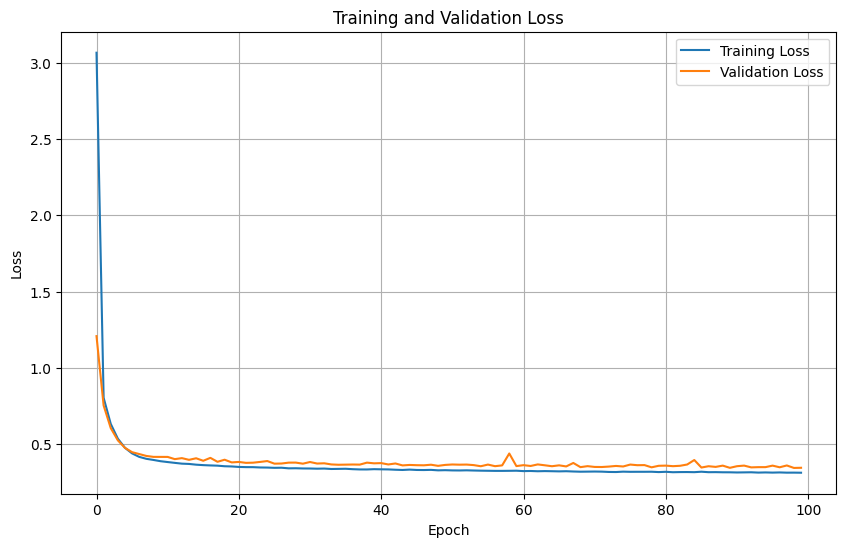

In [7]:
# 可视化训练过程
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()
